In [ ]:
!unzip '/content/drive/MyDrive/SkinCancer Pytorch/dataset.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/HAM10000_images/ISIC_0028788.jpg  
  inflating: /content/__MACOSX/HAM10000_images/._ISIC_0028788.jpg  
  inflating: /content/HAM10000_images/ISIC_0029496.jpg  
  inflating: /content/__MACOSX/HAM10000_images/._ISIC_0029496.jpg  
  inflating: /content/HAM10000_images/ISIC_0028950.jpg  
  inflating: /content/__MACOSX/HAM10000_images/._ISIC_0028950.jpg  
  inflating: /content/HAM10000_images/ISIC_0032908.jpg  
  inflating: /content/__MACOSX/HAM10000_images/._ISIC_0032908.jpg  
  inflating: /content/HAM10000_images/ISIC_0026969.jpg  
  inflating: /content/__MACOSX/HAM10000_images/._ISIC_0026969.jpg  
  inflating: /content/HAM10000_images/ISIC_0029482.jpg  
  inflating: /content/__MACOSX/HAM10000_images/._ISIC_0029482.jpg  
  inflating: /content/HAM10000_images/ISIC_0028944.jpg  
  inflating: /content/__MACOSX/HAM10000_images/._ISIC_0028944.jpg  
  inflating: /content/HAM10000_images/ISIC_0024818.jpg  
  inflating: /con

In [ ]:
import torch
import torchvision
import pandas as pd
import numpy as np
import os 
import random
import torch.nn as nn
from torchvision import transforms, datasets
from tqdm import tqdm
from PIL import Image
from shutil import copyfile, move
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score


In [4]:
# make folders to store all source images
os.mkdir('/content/dataset/')
os.mkdir('/content/dataset/src/')
os.mkdir('/content/dataset/src/0.MEL/')
os.mkdir('/content/dataset/src/1.NV/')
os.mkdir('/content/dataset/src/2.BCC/')
os.mkdir('/content/dataset/src/3.AKIEC/')
os.mkdir('/content/dataset/src/4.BKL/')
os.mkdir('/content/dataset/src/5.DF/')
os.mkdir('/content/dataset/src/6.VASC/')

# make folders for training images for each cancer type
os.mkdir('/content/dataset/train/')
os.mkdir('/content/dataset/train/0.MEL/')
os.mkdir('/content/dataset/train/1.NV/')
os.mkdir('/content/dataset/train/2.BCC/')
os.mkdir('/content/dataset/train/3.AKIEC/')
os.mkdir('/content/dataset/train/4.BKL/')
os.mkdir('/content/dataset/train/5.DF/')
os.mkdir('/content/dataset/train/6.VASC/')

# make folders for validation images for each cancer type
os.mkdir('/content/dataset/val/')
os.mkdir('/content/dataset/val/0.MEL/')
os.mkdir('/content/dataset/val/1.NV/')
os.mkdir('/content/dataset/val/2.BCC/')
os.mkdir('/content/dataset/val/3.AKIEC/')
os.mkdir('/content/dataset/val/4.BKL/')
os.mkdir('/content/dataset/val/5.DF/')
os.mkdir('/content/dataset/val/6.VASC/')

In [5]:
src_bcc = '/content/dataset/src/2.BCC/'
src_akiec = '/content/dataset/src/3.AKIEC/'
src_vasc = '/content/dataset/src/6.VASC/'
src_df = '/content/dataset/src/5.DF/'
src_nv = '/content/dataset/src/1.NV/'
src_mel = '/content/dataset/src/0.MEL/'
src_bkl = '/content/dataset/src/4.BKL/'

train_bcc = '/content/dataset/train/2.BCC/'
train_akiec = '/content/dataset/train/3.AKIEC/'
train_vasc = '/content/dataset/train/6.VASC/'
train_df = '/content/dataset/train/5.DF/'
train_nv = '/content/dataset/train/1.NV/'
train_mel = '/content/dataset/train/0.MEL/'
train_bkl = '/content/dataset/train/4.BKL/'

val_bcc = '/content/dataset/val/2.BCC/'
val_akiec = '/content/dataset/val/3.AKIEC/'
val_vasc = '/content/dataset/val/6.VASC/'
val_df = '/content/dataset/val/5.DF/'
val_nv = '/content/dataset/val/1.NV/'
val_mel = '/content/dataset/val/0.MEL/'
val_bkl = '/content/dataset/val/4.BKL/'

In [6]:
# make sure metadata.csv is in /content
meta = pd.read_csv(r'/content/HAM10000_metadata.csv')
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
len(meta)

10015

In [8]:
# the dataset contains duplicates. This can cause overfitting as well as affect our accuracy calculation if there are duplicates in validation set
meta = meta.drop_duplicates(subset='lesion_id')
len(meta)

7470

In [9]:
# save all image ids and corresponding classes to seggregate the image dataset in folders
img_ids = [i for i in meta['image_id']]
classes = [j for j in meta['dx']]

In [10]:
# loop to put all images in correct folders according to cancer classes
all_images = '/content/HAM10000_images'

for index, image in enumerate(img_ids):
    image = image + '.jpg'
    if classes[index] == 'bcc':
        copyfile(os.path.join(all_images, image), os.path.join(src_bcc, image))
    elif classes[index] == 'akiec':  
        copyfile(os.path.join(all_images, image), os.path.join(src_akiec, image))
    elif classes[index] == 'vasc': 
        copyfile(os.path.join(all_images, image), os.path.join(src_vasc, image))
    elif classes[index] == 'df':
        copyfile(os.path.join(all_images, image), os.path.join(src_df, image))
    elif classes[index] == 'nv': 
        copyfile(os.path.join(all_images, image), os.path.join(src_nv, image))       
    elif classes[index] == 'mel':
        copyfile(os.path.join(all_images, image), os.path.join(src_mel, image))
    elif classes[index] == 'bkl': 
        copyfile(os.path.join(all_images, image), os.path.join(src_bkl, image))

     

In [11]:
# function to split dataset in training and validation sets
def split(src_loc, train_loc, val_loc):   
    # putting all image names in a list 
    image_names = []
    for image in os.listdir(src_loc):
        if os.path.getsize(src_loc + image) > 0:
            image_names.append(image)

    # splitting 80/20
    train_len = int(len(image_names) * 0.8)
    val_len = int(len(image_names) - train_len)

    # shuffle the images as a good measure
    radomized_images = random.sample(image_names, len(image_names))

    # splitting the dataset in training and validation sets
    train_set = radomized_images[0:train_len]
    val_set = radomized_images[:val_len]

    # store the images in training and validation folders for the correct cancer class
    for image in train_set:
        copyfile(src_loc + image, train_loc + image)

    for image in val_set:
        copyfile(src_loc + image, val_loc + image)

In [12]:
split(src_bcc, train_bcc, val_bcc)
split(src_akiec, train_akiec, val_akiec)
split(src_vasc, train_vasc, val_vasc)
split(src_df, train_df, val_df)
split(src_nv, train_nv, val_nv)
split(src_mel, train_mel, val_mel)
split(src_bkl, train_bkl, val_bkl)


In [13]:
train_dir = r'/content/dataset/train/'
val_dir = r'/content/dataset/val/'

In [14]:
# defining transforms
# we resize to 224x224 as that's the expected image size for densenet121, we apply horizontal and vertical flips, rotation and jitter to increase robustness of the dataset as images for some classes are very small

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    ])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
    ])

train_dataset = datasets.ImageFolder(
    train_dir, transform=train_transform)

val_dataset = datasets.ImageFolder(
    val_dir, transform=val_transform)

In [15]:
batch_size = 64
learning_rate = 1e-3

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size = batch_size, shuffle=True)

In [16]:
# defining training parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# using densenet121 model initialized with Imagenet for faster convergence. We will replace classfier layer and train all layers (no frozen layers).
model = torchvision.models.densenet121(pretrained=True).to(device)

num_feats = model.classifier.in_features
model.classifier = nn.Linear(num_feats, 7).to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


writer = SummaryWriter(log_dir='/content/drive/MyDrive/skin_cancer_logs/')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [20]:
epochs = 30
patience = 10
best_val_loss = None
count_no_gain = 0

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training 
    for inputs, gts in train_loader:
        model.train()
        inputs =  inputs.to(device)
        gts = gts.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss = criterion(outputs, gts)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()

    # Validation 
    with torch.no_grad():
        for inputs, gts in val_loader:
            model.eval()    
            inputs =  inputs.to(device)
            gts = gts.to(device)       
            outputs = model(inputs)
            loss = criterion(outputs, gts)
            val_loss += loss.item()
            pred = torch.max(outputs, 1)[1]

    # print results for the epoch
    avg_val_loss = val_loss / len(val_loader)
    avg_train_loss = train_loss / len(train_loader)

    print("Epoch " + str(epoch+1))
    print("Train Loss : " + str(avg_train_loss) )
    print("Val Loss : " + str(avg_val_loss) )


    # write resuts
    writer.add_scalar('Train_loss', train_loss / len(train_loader), epoch+1)
    writer.add_scalar('val_loss', val_loss / len(val_loader), epoch+1)

    # we will early stop training and save best model if model is not improving for long
    if best_val_loss is None:
      best_val_loss = avg_val_loss
      torch.save(model.state_dict(), f'/content/drive/MyDrive/skincancer.pt')  
    
    elif best_val_loss <= avg_val_loss:
      best_val_loss = avg_val_loss
      count_no_gain = 0
      torch.save(model.state_dict(), f'/content/drive/MyDrive/skincancer.pt') 

    else:
      count_no_gain += 1
      if(count_no_gain >= patience):
        print("Stopping early, no decrease in loss for " + str(patience) + " epochs.")
        
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('/content/drive/MyDrive/skincancer.pt'))  

Epoch 1
Train Loss : 0.4343136075012227
Val Loss : 0.39751267929871875
Epoch 2
Train Loss : 0.41011480971219694
Val Loss : 0.41533994550506276
Epoch 3
Train Loss : 0.4124577222986424
Val Loss : 0.47611039752761525
Epoch 4
Train Loss : 0.39163736729545795
Val Loss : 0.314992917701602
Epoch 5
Train Loss : 0.38321544959190046
Val Loss : 0.34267404427131015
Epoch 6
Train Loss : 0.3772837307224882
Val Loss : 0.33323935481409234
Epoch 7
Train Loss : 0.3632181415215452
Val Loss : 0.3028605133295059
Epoch 8
Train Loss : 0.36592800820127447
Val Loss : 0.33071080098549527
Epoch 9
Train Loss : 0.3474306457854332
Val Loss : 0.28561589618523914
Epoch 10
Train Loss : 0.3500287788028413
Val Loss : 0.2998076571772496
Epoch 11
Train Loss : 0.3166899157965437
Val Loss : 0.35859509247044724
Epoch 12
Train Loss : 0.330591729029696
Val Loss : 0.2776098611454169
Epoch 13
Train Loss : 0.3171773174024643
Val Loss : 0.2512629237025976
Stopping early, no decrease in loss for 10 epochs.
Epoch 14
Train Loss : 0.3

KeyboardInterrupt: ignored

              precision    recall  f1-score   support

         MEL       0.70      0.76      0.73       123
          NV       0.96      0.97      0.96      1081
         BCC       0.62      0.91      0.74        66
       AKIEC       0.90      0.41      0.57        46
         BKL       0.88      0.66      0.76       146
          DF       0.75      0.80      0.77        15
        VASC       0.90      0.95      0.93        20

    accuracy                           0.90      1497
   macro avg       0.82      0.78      0.78      1497
weighted avg       0.91      0.90      0.90      1497

AUC of MEL: 0.9746630217393877
AUC of NV: 0.9881764569842738
AUC of BCC: 0.9943565635389535
AUC of AKIEC: 0.9877745482875379
AUC of BKL: 0.9828944566683229
AUC of DF: 0.9966261808367072
AUC of VASC: 0.9998645903859175


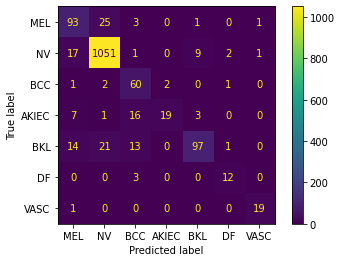

In [21]:
# get all predictions, ground truths and predictions auc
all_preds = torch.zeros(0,dtype=torch.long)
all_gts = torch.zeros(0,dtype=torch.long)
all_preds_auc = torch.zeros(0,dtype=torch.long)

with torch.no_grad():
    for inputs, gts in val_loader:
        model.eval()
        inputs = inputs.to(device)
        gts = gts.to(device)
        outputs = model(inputs)
        preds = torch.max(outputs, 1)[1]

        all_preds = torch.cat([all_preds.view(-1).cpu() ,preds.view(-1).cpu()])
        all_gts = torch.cat([all_gts.view(-1).cpu(),gts.view(-1).cpu()])
        all_preds_auc = torch.cat([all_preds_auc,nn.functional.softmax(outputs, dim=1).cpu()])

all_preds = all_preds .numpy()
all_gts = all_gts.numpy()
all_preds_auc = all_preds_auc.numpy()

# display confusion matrix, classification report and AUC 
matrix = confusion_matrix(all_gts, all_preds)
classes = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']

ConfusionMatrixDisplay(matrix, display_labels=classes).plot(values_format="d")

print(classification_report(all_gts, all_preds, target_names=classes))

one_hot = nn.functional.one_hot(torch.tensor([all_gts]), num_classes=7)
all_auc = roc_auc_score(one_hot.view([all_preds_auc.shape[0], all_preds_auc.shape[1]]), 
                                          all_preds_auc, multi_class='ovr', average=None)
for index, cancer_type in enumerate(classes):
    print("AUC of " + cancer_type + ": " + str(all_auc[index]))